**Reading the data and specifying the target to predict.**

In [134]:
import numpy as np
import pandas as pd
import random
import warnings

warnings.simplefilter("ignore")

random.seed(42)
np.random.seed(42)

train_key = 'sales'

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print(train.shape)

X = train.drop(columns=[train_key])
y = train[train_key]

X_pred = test
submissionId = X_pred.index

(913000, 4)


In [135]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

def negative_mean_absolute_percentage_error(estimator, X, y_true):
    y_pred = estimator.predict(X)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return -(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

def binarize_stores(X_train, X_test, X_pred):
    X_train['store'] = X_train['store'].astype(str)
    X_test['store'] = X_test['store'].astype(str)
    X_pred['store'] = X_pred['store'].astype(str)
    
    lbinarizer = LabelBinarizer()
    lbinarizer.fit(X_train['store'])
    
    binarized_values_train = pd.DataFrame(data=lbinarizer.transform(X_train['store']),
                                        index=X_train.index,
                                        columns=['store_'+column for column in lbinarizer.classes_])
    X_train = pd.concat(objs=[X_train, binarized_values_train], axis=1)
    
    binarized_values_test = pd.DataFrame(data=lbinarizer.transform(X_test['store']),
                                        index=X_test.index,
                                        columns=['store_'+column for column in lbinarizer.classes_])
    X_test = pd.concat(objs=[X_test, binarized_values_test], axis=1)
    
    binarized_values_pred = pd.DataFrame(data=lbinarizer.transform(X_pred['store']),
                                        index=X_pred.index,
                                        columns=['store_'+column for column in lbinarizer.classes_])
    X_pred = pd.concat(objs=[X_pred, binarized_values_pred], axis=1)
    
    X_train.drop(columns='store', inplace=True)
    X_test.drop(columns='store', inplace=True)
    X_pred.drop(columns='store', inplace=True)
    
    return X_train, X_test, X_pred

def binarize_items(X_train, X_test, X_pred):
    X_train['item'] = X_train['item'].astype(str)
    X_test['item'] = X_test['item'].astype(str)
    X_pred['item'] = X_pred['item'].astype(str)
    
    lbinarizer = LabelBinarizer()
    lbinarizer.fit(X_train['item'])
    
    binarized_values_train = pd.DataFrame(data=lbinarizer.transform(X_train['item']),
                                        index=X_train.index,
                                        columns=['item_'+column for column in lbinarizer.classes_])
    X_train = pd.concat(objs=[X_train, binarized_values_train], axis=1)
    
    binarized_values_test = pd.DataFrame(data=lbinarizer.transform(X_test['item']),
                                        index=X_test.index,
                                        columns=['item_'+column for column in lbinarizer.classes_])
    X_test = pd.concat(objs=[X_test, binarized_values_test], axis=1)
    
    binarized_values_pred = pd.DataFrame(data=lbinarizer.transform(X_pred['item']),
                                        index=X_pred.index,
                                        columns=['item_'+column for column in lbinarizer.classes_])
    X_pred = pd.concat(objs=[X_pred, binarized_values_pred], axis=1)
    
    X_train.drop(columns='item', inplace=True)
    X_test.drop(columns='item', inplace=True)
    X_pred.drop(columns='item', inplace=True)
    
    return X_train, X_test, X_pred

def split_date(*datasets):
    for dataset in datasets:
        index = dataset.index
        dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
        dataset['day'] = pd.DatetimeIndex(dataset['date']).day
        dataset['month'] = pd.DatetimeIndex(dataset['date']).month
        dataset['year'] = pd.DatetimeIndex(dataset['date']).year
        dataset['dow'] = pd.DatetimeIndex(dataset['date']).dayofweek
        dataset['cw'] = pd.DatetimeIndex(dataset['date']).weekofyear
    return datasets

def preprocess_day(*datasets):
    for dataset in datasets:
        dataset['day_sin'] = np.sin(dataset['day']-1 * (2. * np.pi / 31))
        dataset['day_cos'] = np.cos(dataset['day']-1 * (2. * np.pi / 31))
        dataset.drop(columns=['day'], inplace=True)
    return datasets

def preprocess_month(*datasets):
    for dataset in datasets:
        dataset['month_sin'] = np.sin(dataset['month']-1 * (2. * np.pi / 12))
        dataset['month_cos'] = np.cos(dataset['month']-1 * (2. * np.pi / 12))
        dataset.drop(columns=['month'], inplace=True)
    return datasets

def preprocess_dow(*datasets):
    for dataset in datasets:
        dataset['dow_sin'] = np.sin(dataset['dow'] * (2. * np.pi / 7))
        dataset['dow_cos'] = np.cos(dataset['dow'] * (2. * np.pi / 7))
        dataset.drop(columns=['dow'], inplace=True)
    return datasets
    
def preprocess_cw(*datasets):
    for dataset in datasets:
        dataset['cw_sin'] = np.sin(dataset['cw']-1 * (2. * np.pi / 53))
        dataset['cw_cos'] = np.cos(dataset['cw']-1 * (2. * np.pi / 53))
        dataset.drop(columns=['cw'], inplace=True)
    return datasets

def plot_by_date(X, y):
    X['sales'] = y
    
    plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
    plt.subplot(2,2, 1)
    plt.title('Sales by Day of Week')
    data_by_dow = X.groupby(['dow']).aggregate(np.mean)
    plt.plot(data_by_dow.index, data_by_dow['sales'], linestyle=':', markersize=0.1)

    plt.subplot(2,2, 2)
    plt.title('Sales by Calendar Week')
    data_by_cw = X.groupby(['cw']).aggregate(np.mean)
    plt.plot(data_by_cw.index, data_by_cw['sales'], linestyle=':', markersize=0.1)
    
    plt.subplot(2,2, 3)
    plt.title('Sales by Month')
    data_by_dow = X.groupby(['month']).aggregate(np.mean)
    plt.plot(data_by_dow.index, data_by_dow['sales'], linestyle=':', markersize=0.1)
    
    plt.subplot(2,2, 4)
    plt.title('Sales by Year')
    data_by_year = X.groupby(['year']).aggregate(np.mean)
    plt.plot(data_by_year.index, data_by_year['sales'], linestyle=':', markersize=0.1)
        
    X.drop(columns='sales', inplace=True)

    plt.show()
    
def plot_by_date_and_store(X, y):
    X['sales'] = y
    
    plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
    ax1 = plt.subplot(2,2, 1)
    plt.title('Sales per Store by Day of Week')
    X.groupby(['dow','store']).mean()['sales'].unstack().plot(ax=ax1)
    
    ax2 = plt.subplot(2,2, 2)
    plt.title('Sales per Store by Calendar Week')
    X.groupby(['cw','store']).mean()['sales'].unstack().plot(ax=ax2)
    
    ax3 = plt.subplot(2,2, 3)
    plt.title('Sales per Store by Month')
    X.groupby(['month','store']).mean()['sales'].unstack().plot(ax=ax3)
    
    ax4 = plt.subplot(2,2, 4)
    plt.title('Sales per Store by Year')
    X.groupby(['year','store']).mean()['sales'].unstack().plot(ax=ax4)
    
    X.drop(columns='sales', inplace=True)
    
    plt.show()
    
def plot_by_date_and_item(X, y):
    X['sales'] = y
    
    plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
    ax1 = plt.subplot(2,2, 1)
    plt.title('Sales per Item by Day of Week')
    X.groupby(['dow','item']).mean()['sales'].unstack().plot(ax=ax1)
    
    ax2 = plt.subplot(2,2, 2)
    plt.title('Sales per Item by Calendar Week')
    X.groupby(['cw','item']).mean()['sales'].unstack().plot(ax=ax2)
    
    ax3 = plt.subplot(2,2, 3)
    plt.title('Sales per Item by Month')
    X.groupby(['month','item']).mean()['sales'].unstack().plot(ax=ax3)
    
    ax4 = plt.subplot(2,2, 4)
    plt.title('Sales per Item by Year')
    X.groupby(['year','item']).mean()['sales'].unstack().plot(ax=ax4)
    
    X.drop(columns='sales', inplace=True)
    
    plt.show()
    
def plot_sales_by_store_and_item(X, y):
    X['sales'] = y
    plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    data = pd.DataFrame(data=X.groupby(['store','item']).count()['sales'])
    data.reset_index(inplace=True)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(xs=data['store'], ys=data['item'], zs=data['sales'])
    
    X.drop(columns='sales', inplace=True)
    
    plt.show()

**Exploratory Data Analysis**
1. Exploring the seasonality in different dimensions (Calendar Week, Day of Week, Month, Year)
2. Exploring the seaonality in the same dimensions by stores
3. Exploring the seasonality in the same dimensions by item

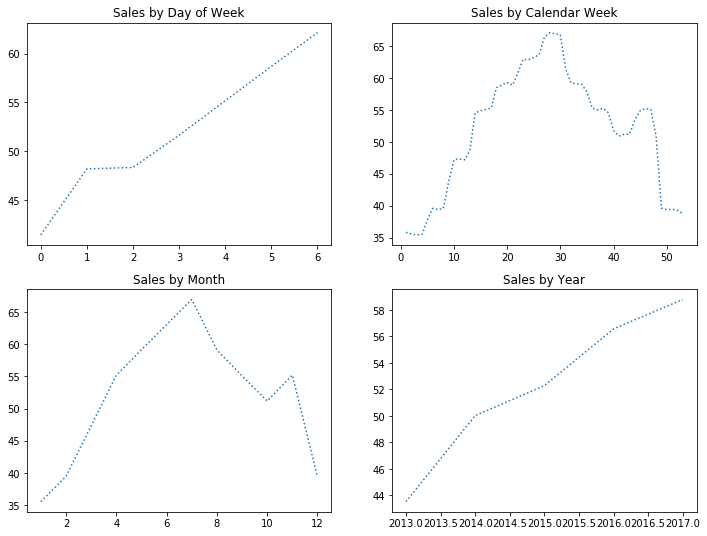

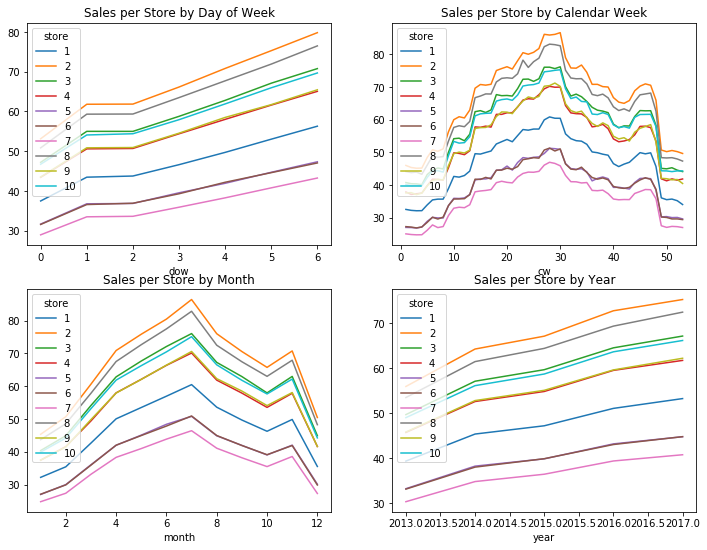

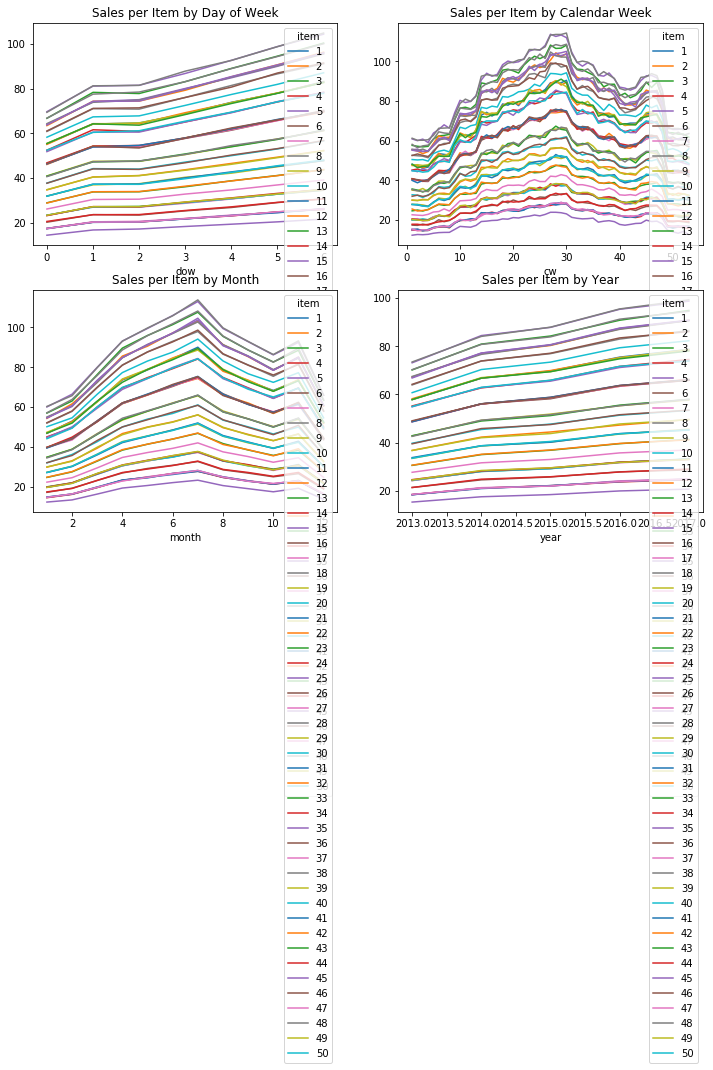

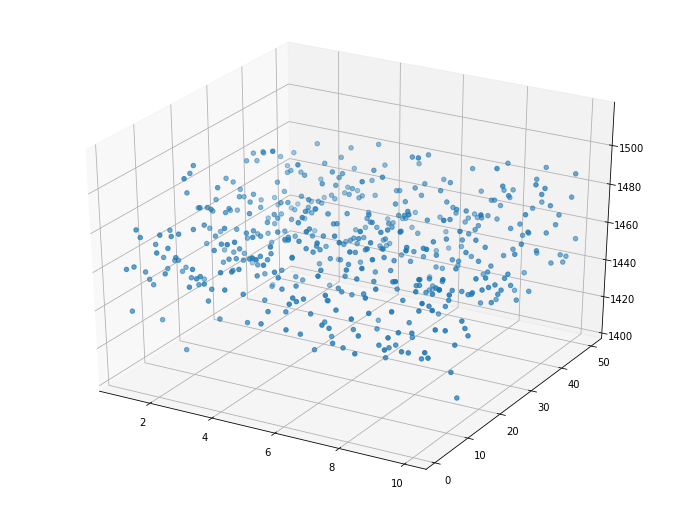

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_test, X_pred = split_date(X_train, X_test, X_pred)
plot_by_date(X_train, y_train)
plot_by_date_and_store(X_train, y_train)
plot_by_date_and_item(X_train, y_train)
plot_sales_by_store_and_item(X_train, y_train)

**Approach I: Machine Learning**
Prediction by training the multiple ML algorithms.

In [137]:
from sklearn.model_selection import GridSearchCV

def train_gridsearch_cv(model, X_train, y_train, param_grid={}):
    clf = GridSearchCV(cv=5,
                       estimator=model,
                       param_grid=param_grid,
                       n_jobs=-1,
                       verbose=1,
                       scoring='neg_mean_squared_error')
    clf.fit(X=X_train, y=y_train)
    print("MSE", -clf.best_score_)
    return clf.best_estimator_

In [138]:
#X_train, X_test, X_pred = binarize_stores(X_train, X_test, X_pred)
#X_train, X_test, X_pred = binarize_items(X_train, X_test, X_pred)
X_train, X_test, X_pred = split_date(X_train, X_test, X_pred)
#X_train, X_test, X_pred = preprocess_day(X_train, X_test, X_pred)
#X_train, X_test, X_pred = preprocess_month(X_train, X_test, X_pred)

X_train.drop(columns='date', inplace=True)
X_test.drop(columns='date', inplace=True)
X_pred.drop(columns='date', inplace=True)

In [139]:
from sklearn.linear_model import ElasticNet

model_el = ElasticNet()
model_el.fit(X_train, y_train)

print("MAPE:", round(-negative_mean_absolute_percentage_error(estimator=model_el, 
                                                        X=X_test, 
                                                        y_true=y_test),2))

MAPE: 63.67


In [140]:
def get_item_factor(X, y):
    X['sales'] = y
    grand_average = X['sales'].mean()
    average_per_item = X.groupby(['item']).mean()['sales']
    average_per_item = pd.DataFrame(average_per_item)
    average_per_item.rename(columns={'sales': 'sales_mean'}, inplace=True)
    average_per_item['sales_mean_normalized'] = average_per_item['sales_mean']/grand_average
    X.drop(columns='sales', inplace=True)
    return(average_per_item)

def get_store_factor(X, y):
    X['sales'] = y
    grand_average = X['sales'].mean()
    average_per_store = X.groupby(['store']).mean()['sales']
    average_per_store = pd.DataFrame(average_per_store)
    average_per_store.rename(columns={'sales': 'sales_mean'}, inplace=True)
    average_per_store['sales_mean_normalized'] = average_per_store['sales_mean']/grand_average
    X.drop(columns='sales', inplace=True)
    return(average_per_store)

def get_month_factor(X, y):
    X['sales'] = y
    grand_average = X['sales'].mean()
    average_per_month = X.groupby(['month']).mean()['sales']
    average_per_month = pd.DataFrame(average_per_month)
    average_per_month.rename(columns={'sales': 'sales_mean'}, inplace=True)
    average_per_month['sales_mean_normalized'] = average_per_month['sales_mean']/grand_average
    X.drop(columns='sales', inplace=True)
    return(average_per_month)

def get_cw_factor(X, y):
    X['sales'] = y
    grand_average = X['sales'].mean()
    average_per_cw = X.groupby(['cw']).mean()['sales']
    average_per_cw = pd.DataFrame(average_per_cw)
    average_per_cw.rename(columns={'sales': 'sales_mean'}, inplace=True)
    average_per_cw['sales_mean_normalized'] = average_per_cw['sales_mean']/grand_average
    X.drop(columns='sales', inplace=True)
    return(average_per_cw)

def get_dow_factor(X, y):
    X['sales'] = y
    grand_average = X['sales'].mean()
    average_per_dow = X.groupby(['dow']).mean()['sales']
    average_per_dow = pd.DataFrame(average_per_dow)
    average_per_dow.rename(columns={'sales': 'sales_mean'}, inplace=True)
    average_per_dow['sales_mean_normalized'] = average_per_dow['sales_mean']/grand_average
    X.drop(columns='sales', inplace=True)
    return(average_per_dow)

def get_annualy_growth(X, y):
    X['sales'] = y
    grand_average = X['sales'].mean()
    average_per_year = X.groupby(['year']).mean()['sales']
    average_per_year = pd.DataFrame(average_per_year)
    average_per_year.rename(columns={'sales': 'sales_mean'}, inplace=True)
    average_per_year['sales_mean_normalized'] = average_per_year['sales_mean']/grand_average
    growth_factor = 1+(average_per_year['sales_mean_normalized'][2017] - average_per_year['sales_mean_normalized'][2013])/5
    X.drop(columns='sales', inplace=True)
    return(growth_factor)

In [ ]:
X['sales'] = y
grand_average = X['sales'].mean()
item_factor = get_item_factor(X_train, y_train)
store_factor = get_store_factor(X_train, y_train)
cw_factor = get_cw_factor(X_train, y_train)
dow_factor = get_dow_factor(X_train, y_train)
growth_factor = get_annualy_growth(X_train, y_train)

def predict(item, store, cw, dow, year):
    pred = grand_average * item_factor['sales_mean_normalized'][item] * store_factor['sales_mean_normalized'][store] * cw_factor['sales_mean_normalized'][cw] * dow_factor['sales_mean_normalized'][dow] * (year-2017)*growth_factor
    return(pred)

In [ ]:
prediction = []
for idx, row in X_pred.iterrows():
    prediction.append(predict(X_pred['item'][idx], X_pred['store'][idx], X_pred['cw'][idx], X_pred['dow'][idx], X_pred['year'][idx]))

**Submission**

In [ ]:
submission = pd.DataFrame({'Id': submissionId, 'sales': prediction})
# you could use any filename. We choose submission here
submission.to_csv('submission.csv', index=False)